#<span style="color:#0b486b">SIT 112 - Data Science Concepts</span>

---
Lecturer: Dinh Phung | dinh.phung@deakin.edu.au<br />
Assistant: Adham Beyki | abeyki@deakin.edu.au

School of Information Technology, <br />
Deakin University, VIC 3215, Australia.

---
## <span style="color:#0b486b">Practical Session 9: Geo-visualization - k-Nearest Neighbors</span> 
**The purpose of this session is to demonstrate:**

1. Visualizing geographical data on a map
  1. Using JavaScript in IPython Notebooks
2. k-Nearest Neighbors classification technique

---
## <span style="color:#0b486b">Geo-Visualization</span> 
By now you should be familiar with geo-tagged data. Data such as photos that you take with your cell phone (assuming the GPS and geo-tagging on your phone is activated), tweets that you send, and etc. In this section we intend to visualize geographical information. We will use JavaScript and Google Maps API to show them as points on a map. First we need some geo-tagged data. Let's crawl some tweets.

In [ ]:
from TwitterAPI import TwitterAPI

CONSUMER_KEY = "EtkzSepve4nXCZvgs9ECtXRj5"
CONSUMER_SECRET = "MWqp90r1isH9Bcd2uSCoIgSVvh0BxUeWJHEqJiU0aF8W7wLlIG"
OAUTH_TOKEN = "1500504792-yLmZCK8jzEchyPAcI5ZJCXKHKZu2pL1TuwQWtQI"
OAUTH_TOKEN_SECRET = "KoYg8xd8PgMRV2e797iWzObm170U5WfIldYf7hLYxVo"

# Authonticating with your application credentials
api = TwitterAPI(CONSUMER_KEY,
                 CONSUMER_SECRET,
                 OAUTH_TOKEN,
                 OAUTH_TOKEN_SECRET)

In [ ]:
# geo coordinations of the desired place

my_lat = -37.81
my_long = 144.97

resp = api.request('search/tweets', {'q':'pizza', 
                                     'count':'100', 
                                     'lang':'en', 
                                     'result_type':'recent',
                                     'geocode':'{},{},100mi'.format(my_lat, my_long)})
for r in resp:
    print r['text']

Although we have specified the geo-location in our Twitter query, not all the tweets in `response object` actually are geo-tagged. We remove them and keep, username, tweet message, and lat-long of the tweet.

In [ ]:
clean_data = []

for r in resp:
    data = []
    try:
        user_name = r['user']['name'].encode('ascii', 'ignore')    # username
        tweet_text = r['text'].encode('ascii', 'ignore')            # tweet message
        data.append("{}: {}".format(user_name, tweet_text))
        data.append(r['geo']['coordinates'][0])    # lat
        data.append(r['geo']['coordinates'][1])    # long
        clean_data.append(data)
    except TypeError, e:
        print "lat, long not availabe. "

In [ ]:
clean_data

Now our data is ready for visualization.

### <span style="color:#0b486b">magic functions</span> 


Before we move on it is better to introduce `magic` functions. IPython magic functions allow you to control the behaviour of the IPython itself and a lot of system features. Any line whose first character is % is considered to be a magic function.

In [ ]:
%cd

In [ ]:
%timeit x = range(1000)

`magic` cell:

In [ ]:
%%javascript

alert("Hello World!")

### <span style="color:#0b486b">Using Google Maps API</span> 


`core.display` module offers top-level functions for displaying objects in different formats in Ipython Notebook. We use `HTML` and `Javascript` which create a HTML and JavaScript representation of the object respectively. Also note the double percentage sign (%%) at the beginning of cells. %% and the following term are called `magic functions` and cause the cell to behave differently. For example %%javascript at the beginning of a cell, runs the cell block of Javascript code.

In [ ]:
from IPython.core.display import HTML, Javascript

In [ ]:
# load the Google Maps API library

def gmap_init():
    js = """
window.gmap_initialize = function() {};
$.getScript('https://maps.googleapis.com/maps/api/js?v=3&sensor=false&callback=gmap_initialize');
    """
    return Javascript(data=js)

gmap_init()

In [ ]:
%%html
<style type="text/css">
  .map-canvas { height: 400px; }
</style

In [ ]:
%%html
<div id="markers" class="map-canvas"/>

In [ ]:
def myfun(data, center_lat, center_long):
    
    js = "var data = " + str(data)
    js += """

var map = new google.maps.Map(document.getElementById('markers'),
                              {{zoom: 10,
                               center: new google.maps.LatLng({}, {}),
                               mapTypeId: google.maps.MapTypeId.ROADMAP
                              }});
""".format(center_lat, center_long)
    js += """                              

var infowindow = new google.maps.InfoWindow();

var i;
for (i = 0; i < data.length; i++) {
    var marker = new google.maps.Marker({
        position: new google.maps.LatLng(data[i][1], data[i][2]),
        map: map});

    google.maps.event.addListener(marker, 'click', (function(marker, i) {
        return function() {
            infowindow.setContent(data[i][0]);
            infowindow.open(map, marker);
        }
    })(marker, i));
}
"""
    return Javascript(js)

In [ ]:
myfun(clean_data, my_lat, my_long)

---
### <span style="color:#0b486b">k-Nearest Neighbours Classification</span> 

kNN is a non-parametric classification technique which is extensively used in practice. Its input consists of the `k` closest training examples and the output is a class membership. An object is classified by a majority vote of its neighbors, with the object being assigned to the class most common among its `k` nearest neighbors (k is a positive integer, typically small). If k = 1, then the object is simply assigned to the class of that single nearest neighbor.

**Please note that kNN is different from K-means.** K-means is a clustering algorithm that tries to partition a set of points into K sets (clusters) such that the points in each cluster be close to each other. It is unsupervised because the points have no external classification. kNN is a classification algorithm that in order to determine the classification of a point, combines the class of the k nearest points. It is supervised because you are trying to classify a point based on the known label of other points.

### <span style="color:#0b486b">kNN in Python</span> 

To be able to illustrate how we perform kNN classification in Python, we need some data first. Therefore we synthesize some data from 3 classes. We assume the data in each class comes from a multivariate random distribution.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set()

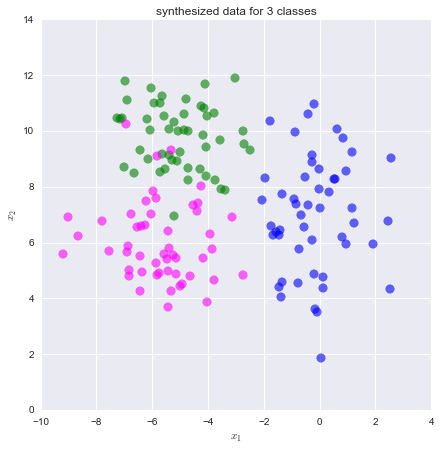

In [2]:
np.random.seed(100)
n_per_class = 50
colors = ['green', 'blue', 'magenta']

mean1 = [-5, 10]
cov1 = [[1.5, 0], [0, 1.5]]
mean2 = [0, 7]
cov2 = [[1.5, 0], [0, 3]]
mean3 = [-6, 6]
cov3 = [[2, 0], [0, 1.5]]

means = [mean1, mean2, mean3]
covs = [cov1, cov2, cov3]

x11, x12 = np.random.multivariate_normal(means[0], covs[0], n_per_class).T
x21, x22 = np.random.multivariate_normal(means[1], covs[1], n_per_class).T
x31, x32 = np.random.multivariate_normal(means[2], covs[2], n_per_class).T

scale = 75
alpha = 0.6

fig, ax  = plt.subplots(figsize=(7, 7), dpi=300)
ax.scatter(x11, x12, alpha=alpha, color=colors[0], s=scale)
ax.scatter(x21, x22, alpha=alpha, color=colors[1], s=scale)
ax.scatter(x31, x32, alpha=alpha, color=colors[2], s=scale)

ax.set_title("synthesized data for 3 classes")
ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_2$")

Then we have to instantiate a kNN classifier from sklearn.

In [3]:
from sklearn import neighbors

weights='uniform'
k = 15
knn = neighbors.KNeighborsClassifier(k,weights=weights)

We need to pass one array as training features and on array as training labels to the `knn` object. Therefore we have to put all the attributes together (also class labels).

In [4]:
x1 = np.r_[x11, x21, x31]
x2 = np.r_[x12, x22, x32]
X_train = np.c_[x1, x2]

In [5]:
Y_train = np.r_[0*np.ones(n_per_class), 1*np.ones(n_per_class), 2*np.ones(n_per_class)]

Now we can fit the model

In [6]:
knn.fit(X_train, Y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_neighbors=15, p=2, weights='uniform')

Now we will see how kNN classifies a point.

In [37]:
k = 1
knn = neighbors.KNeighborsClassifier(k)
knn.fit(X_train, Y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_neighbors=1, p=2, weights='uniform')

In [33]:
from matplotlib.colors import ListedColormap
cmap_bold = ListedColormap(['green', 'blue', 'magenta'])

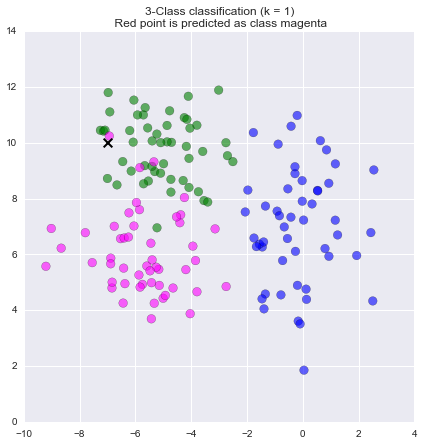

In [38]:
fig,ax = plt.subplots(figsize=(7, 7))

ax.scatter(X_train[:, 0], X_train[:, 1], c=Y_train, cmap=cmap_bold, alpha=alpha, s=scale)

plt.title("3-Class classification (k = {})".format(k))

X_test = [-7, 10]
Y_pred = knn.predict(X_test)
ax.scatter(X_test[0], X_test[1], marker="x", s=scale, lw=2, c='k')

ax.set_title("3-Class classification (k = {})\n Red point is predicted as class {}".format(k, colors[Y_pred.astype(int)[0]]))

### <span style="color:#0b486b">Decision Boundry</span> 

kNN effectively partitions the feature space into different sets and assigns the same class label to points belonging to the same partition. This partitioning changes as we change k. We illustrate this below. As you see bigger values of k, partition the space more smoothly.

In [34]:
from matplotlib.colors import ListedColormap

In [ ]:
k = 15
knn = neighbors.KNeighborsClassifier(k, weights=weights)
knn.fit(X_train, Y_train)

# step size in the mesh
h = 0.05

# Create colour maps
cmap_light = ListedColormap(['#AAFFAA', '#AAAAFF', '#FFAAAA'])
cmap_bold = ListedColormap(['green', 'blue', 'magenta'])

x1_min, x1_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
x2_min, x2_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, h), np.arange(x2_min, x2_max, h))

Z = knn.predict(np.c_[xx1.ravel(), xx2.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx1.shape)

fig,ax = plt.subplots(figsize=(7, 7))
ax.pcolormesh(xx1, xx2, Z, cmap=cmap_light)

# Plot also the training points
ax.scatter(X_train[:, 0], X_train[:, 1], c=Y_train, cmap=cmap_bold, alpha=alpha, s=scale)

plt.xlim(xx1.min(), xx1.max())
plt.ylim(xx2.min(), xx2.max())
plt.title("3-Class classification (k = {})".format(k))

Now we will investigate the effect of `'k'` on decision boundaries. Lets train a classifier with `k=1` which means we only use the label of the closest point to predict the label of a test point.

In [ ]:
k = 1
knn = neighbors.KNeighborsClassifier(k, weights=weights)
knn.fit(X_train, Y_train)

Z = knn.predict(np.c_[xx1.ravel(), xx2.ravel()])
Z = Z.reshape(xx1.shape)

fig,ax = plt.subplots(figsize=(7, 7))
ax.pcolormesh(xx1, xx2, Z, cmap=cmap_light)

ax.scatter(X_train[:, 0], X_train[:, 1], c=Y_train, cmap=cmap_bold, alpha=alpha, s=scale)

plt.xlim(xx1.min(), xx1.max())
plt.ylim(xx2.min(), xx2.max())
plt.title("3-Class classification (k = {})".format(k))

In [ ]:
k = 2
knn = neighbors.KNeighborsClassifier(k, weights=weights)
knn.fit(X_train, Y_train)

Z = knn.predict(np.c_[xx1.ravel(), xx2.ravel()])
Z = Z.reshape(xx1.shape)

fig,ax = plt.subplots(figsize=(7, 7))
ax.pcolormesh(xx1, xx2, Z, cmap=cmap_light)

ax.scatter(X_train[:, 0], X_train[:, 1], c=Y_train, cmap=cmap_bold, alpha=alpha, s=scale)

plt.xlim(xx1.min(), xx1.max())
plt.ylim(xx2.min(), xx2.max())
plt.title("3-Class classification (k = {})".format(k))

In [ ]:
k = 3
knn = neighbors.KNeighborsClassifier(k, weights=weights)
knn.fit(X_train, Y_train)

Z = knn.predict(np.c_[xx1.ravel(), xx2.ravel()])
Z = Z.reshape(xx1.shape)

fig,ax = plt.subplots(figsize=(7, 7))
ax.pcolormesh(xx1, xx2, Z, cmap=cmap_light)

ax.scatter(X_train[:, 0], X_train[:, 1], c=Y_train, cmap=cmap_bold, alpha=alpha, s=scale)

plt.xlim(xx1.min(), xx1.max())
plt.ylim(xx2.min(), xx2.max())
plt.title("3-Class classification (k = {})".format(k))

In [ ]:
k = 5
knn = neighbors.KNeighborsClassifier(k, weights=weights)
knn.fit(X_train, Y_train)

Z = knn.predict(np.c_[xx1.ravel(), xx2.ravel()])
Z = Z.reshape(xx1.shape)

fig,ax = plt.subplots(figsize=(7, 7))
ax.pcolormesh(xx1, xx2, Z, cmap=cmap_light)

ax.scatter(X_train[:, 0], X_train[:, 1], c=Y_train, cmap=cmap_bold, alpha=alpha, s=scale)

plt.xlim(xx1.min(), xx1.max())
plt.ylim(xx2.min(), xx2.max())
plt.title("3-Class classification (k = {})".format(k))

####Prediction

Play with the `X_test` and `k` to see how the classifier behaves.

In [ ]:
k = 5
knn = neighbors.KNeighborsClassifier(k, weights=weights)
knn.fit(X_train, Y_train)

Z = knn.predict(np.c_[xx1.ravel(), xx2.ravel()])
Z = Z.reshape(xx1.shape)

fig,ax = plt.subplots(figsize=(7, 7))
ax.pcolormesh(xx1, xx2, Z, cmap=cmap_light)

ax.scatter(X_train[:, 0], X_train[:, 1], c=Y_train, cmap=cmap_bold, alpha=alpha, s=scale)

plt.xlim(xx1.min(), xx1.max())
plt.ylim(xx2.min(), xx2.max())
plt.title("3-Class classification (k = {})".format(k))

X_test = [-4, 8]
Y_pred = knn.predict(X_test)
ax.scatter(X_test[0], X_test[1], alpha=0.95, color='r', s=3*scale)

ax.set_title("3-Class classification (k = {})\n Red point is predicted as class {}".format(k, colors[Y_pred.astype(int)[0]]))

Now instead of predicting the class label for one point, we use our model to predict the labels of multiple points.

First we generate some test data from the first class. This way we know the true class labels. Then we can use the `kNN` classifier to predict labels for the test data and get the predicted class labels. A measure of  accuracy for the classifier can be defined by comparing the true and predicted labels.

In [ ]:
n_test = 100
X1_test, X2_test = np.random.multivariate_normal(mean1, cov1, n_test).T
Y_true = 0 * np.ones(n_test)

In [ ]:
X_test = np.c_[X1_test, X2_test]

In [ ]:
Y_pred = knn.predict(X_test)

In [ ]:
Y_pred

How many times the classifier predicts the labels correctly?

In [ ]:
Y_pred == Y_true

 Accuracy:

In [ ]:
(sum(Y_pred == Y_true) + 0.0) / n_test

**Exercise**: Repeat the previous experiment with a classifier which has bee trained with a different `k`.

**Exercise**: Use kNN to implement a classifier on handwritten digits dataset introduced in prac7.